In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-12-10 10:15:36--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.128, 142.251.45.16, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   176MB/s    in 0.5s    

2022-12-10 10:15:37 (176 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

In [4]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable=False

In [6]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [7]:
last_layer = pre_trained_model.get_layer('mixed7')
print(last_layer.output_shape)
last_output = last_layer.output

(None, 7, 7, 768)


In [8]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x=layers.Flatten()(last_output)
x=layers.Dense(1024,activation="relu")(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(1,activation="sigmoid")(x)

model=Model(pre_trained_model.input,x)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [10]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),loss="binary_crossentropy",metrics=["accuracy"])

In [11]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-12-10 10:15:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.128, 142.251.45.16, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   115MB/s    in 0.6s    

2022-12-10 10:15:45 (115 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [12]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') 

train_dogs_dir = os.path.join(train_dir, 'dogs') 

validation_cats_dir = os.path.join(validation_dir, 'cats') 

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 97s - loss: 0.3355 - accuracy: 0.8595 - val_loss: 0.2086 - val_accuracy: 0.9270 - 97s/epoch - 971ms/step
Epoch 2/20
100/100 - 95s - loss: 0.2389 - accuracy: 0.9085 - val_loss: 0.1074 - val_accuracy: 0.9590 - 95s/epoch - 953ms/step
Epoch 3/20
100/100 - 92s - loss: 0.2130 - accuracy: 0.9230 - val_loss: 0.1099 - val_accuracy: 0.9610 - 92s/epoch - 922ms/step
Epoch 4/20
100/100 - 95s - loss: 0.2029 - accuracy: 0.9280 - val_loss: 0.1240 - val_accuracy: 0.9540 - 95s/epoch - 948ms/step
Epoch 5/20
100/100 - 94s - loss: 0.1679 - accuracy: 0.9315 - val_loss: 0.1145 - val_accuracy: 0.9670 - 94s/epoch - 939ms/step
Epoch 6/20
100/100 - 95s - loss: 0.1826 - accuracy: 0.9380 - val_loss: 0.1595 - val_accuracy: 0.9540 - 95s/epoch - 952ms/step
Epoch 7/20
100/100 - 92s - loss: 0.1785 - accuracy: 0.9465 - val_loss: 0.1416 - val_accuracy: 0.9650 - 92s/epoch - 921ms/step
Epoch 8/20
100/100 - 94s - loss: 0.1712 - accuracy: 0.9410 - val_loss: 0.3153 - val_accuracy: 0.9270 - 94s/epoch - 938

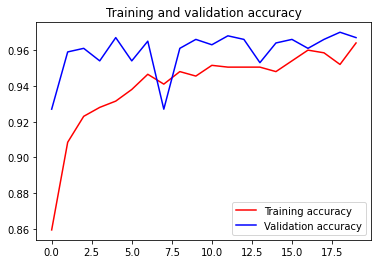

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

We yielded a pretty good model using transfer learning